# Определение перспективного тарифа для телеком-компании

# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Для начала импортируем необходимые для исследования библиоткеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
font = {'family': 'sans-serif',
        'color':  '#a72693',
        'weight': 'normal',
        'size': 20,
        }

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Выгрузим датасеты

In [4]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Далее изучим таблицы

### Посмотрим на таблицу с пользователями

In [5]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Посмотрим на таблицу с звонками

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


### Посмотрим на таблицу с сообщениями

In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


### Посмотрим на таблицу с интернетом

In [11]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


### Посмотрим на таблицу с тарифами

In [13]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Вывод**

В таблице с пользователями видим 38 пользователей, прекративших пользоваться тарифом. Необходимо привести `churn_date` и `reg_date` к `datetime`.

В таблице со звонками также необходимо привести даты к `datetime`. Длительность звонков необходимо округлить, как указано в условии тарифного плана. Если в таблице есть звонки с продолжительностью 0, это пропущенные звонки, удалять их не будем. Столбец `id` приводим к типу `int`.

В таблице с сообщениями необходимо столбец `id` привести к типу int и даты к `datetime`.

В таблице с тарифными планами проблем нет.

## Шаг 2. Подготовка данных

### Приведём данные к нужным типам

В первом **Выводе** мы нашли данные, которые необходимо привести к нужным типам. Исправим их.

Начнем с таблицы пользователей

In [15]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

Проверим

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Далее переходим к таблице со звонками.

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [18]:
calls['id'] = calls['id'].astype('int')

In [19]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [20]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [21]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


Привели данные к нужным типам, округлил длительность звонков.

In [22]:
messages['id'] = messages['id'].astype('int')

In [23]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [25]:
internet['id'] = internet['id'].astype('int')

In [26]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  int64         
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.7 MB


Привели данные в сообщениях и интернете к нужным типам

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [28]:
calls['month'] = calls['call_date'].dt.month

In [29]:
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,7
1,10001,2018-08-17,0,1000,8
2,10002,2018-06-11,3,1000,6
3,10003,2018-09-21,14,1000,9
4,10004,2018-12-15,6,1000,12


In [30]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})

In [31]:
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


### Количество отправленных сообщений по месяцам

In [32]:
messages['month'] = messages['message_date'].dt.month

In [33]:
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


In [34]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [35]:
user_messages.head()

,user_id,month,sms_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика по месяцам

In [36]:
internet['month'] = internet['session_date'].dt.month

In [37]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,10000,112.95,2018-11-25,1000,11
1,1,10001,"1,052.81",2018-09-07,1000,9
2,2,10002,"1,197.26",2018-06-25,1000,6
3,3,10003,550.27,2018-08-22,1000,8
4,4,10004,302.56,2018-09-24,1000,9


In [38]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [39]:
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,5,"2,253.49"
1,1000,6,"23,233.77"
2,1000,7,"14,003.64"
3,1000,8,"14,055.93"
4,1000,9,"14,568.91"


### Выручка за месяц с каждого пользователя

Объединим полученные данные в одну таблицу, добавим тариф и город каждого пользователя, и заменим пропуски на 0. Так как пустое значение соответсвует нулевому потребленю смс/трафика/сообещний в конкретном месяце. Для дальнейшего анализатам понадобиться учитывать и нулевое потребление, например при расчете средней (ведь nan в расчете средней не участвует)

In [40]:
users_consumption = user_calls.merge(user_internet, on=['user_id','month'], how ='outer')
users_consumption.head()

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month
0,1000,5,159.00,22.00,"2,253.49"
1,1000,6,172.00,43.00,"23,233.77"
2,1000,7,340.00,47.00,"14,003.64"
3,1000,8,408.00,52.00,"14,055.93"
4,1000,9,466.00,58.00,"14,568.91"


In [41]:
users_consumption = users_consumption.merge(user_messages, on=['user_id','month'], how ='outer')
users_consumption.head()

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month
0,1000,5,159.00,22.00,"2,253.49",22.00
1,1000,6,172.00,43.00,"23,233.77",60.00
2,1000,7,340.00,47.00,"14,003.64",75.00
3,1000,8,408.00,52.00,"14,055.93",81.00
4,1000,9,466.00,58.00,"14,568.91",57.00


In [42]:
users_consumption = users_consumption.merge(users[['user_id','tariff']], on=['user_id'], how ='left')
users_consumption.head()

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month,tariff
0,1000,5,159.00,22.00,"2,253.49",22.00,ultra
1,1000,6,172.00,43.00,"23,233.77",60.00,ultra
2,1000,7,340.00,47.00,"14,003.64",75.00,ultra
3,1000,8,408.00,52.00,"14,055.93",81.00,ultra
4,1000,9,466.00,58.00,"14,568.91",57.00,ultra


In [43]:
users_consumption = users_consumption.merge(users[['user_id','city']], on=['user_id'], how ='left')
users_consumption.head()

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month,tariff,city
0,1000,5,159.00,22.00,"2,253.49",22.00,ultra,Краснодар
1,1000,6,172.00,43.00,"23,233.77",60.00,ultra,Краснодар
2,1000,7,340.00,47.00,"14,003.64",75.00,ultra,Краснодар
3,1000,8,408.00,52.00,"14,055.93",81.00,ultra,Краснодар
4,1000,9,466.00,58.00,"14,568.91",57.00,ultra,Краснодар


In [44]:
users_consumption.isna().sum()

user_id                   0
month                     0
month_calls_duration     40
calls_total_in_month     40
mb_total_in_month        11
sms_total_in_month      497
tariff                    0
city                      0
dtype: int64

In [45]:
users_consumption.fillna(0, inplace=True)

In [46]:
users_consumption.head(5)

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month,tariff,city
0,1000,5,159.00,22.00,"2,253.49",22.00,ultra,Краснодар
1,1000,6,172.00,43.00,"23,233.77",60.00,ultra,Краснодар
2,1000,7,340.00,47.00,"14,003.64",75.00,ultra,Краснодар
3,1000,8,408.00,52.00,"14,055.93",81.00,ultra,Краснодар
4,1000,9,466.00,58.00,"14,568.91",57.00,ultra,Краснодар


In [47]:
users_consumption.isna().sum()

user_id                 0
month                   0
month_calls_duration    0
calls_total_in_month    0
mb_total_in_month       0
sms_total_in_month      0
tariff                  0
city                    0
dtype: int64

In [48]:
users_consumption.duplicated().sum()

0

Функция для расчета прибыли

In [49]:
def users_revenue(row):       
    tariff = tariffs.loc[tariffs['tariff_name'] == row['tariff']]
    
    # считаем сколько за месяц потратил пользователь исходя из его тарифа
    revenue = 0
    monthly_fee = tariff.iloc[0,3]
    revenue += monthly_fee
    
    # минуты 
    if row['month_calls_duration'] > tariff.iloc[0,2]:
        extra_minutes_cost = (row['month_calls_duration'] - tariff.iloc[0,2]) * tariff.iloc[0,-2]
        revenue += extra_minutes_cost
        
    # сообщения
    if row['sms_total_in_month'] > tariff.iloc[0,0]:
        extra_message_cost = (row['sms_total_in_month'] - tariff.iloc[0,0]) * tariff.iloc[0,-3]
        revenue += extra_message_cost
     
    # трафик
    if row['mb_total_in_month'] > tariff.iloc[0,1]:
        
        # так как клиент может докупать только гигабайты а не мб, рассчитаем сколько гб докупил пользовател
        # и исходя из этого рассчитаем стоимость доп трафика
        
        extra_gb_used = np.ceil((row['mb_total_in_month'] - tariff.iloc[0,1]) / 1024)
        extra_traffic_cost = extra_gb_used * tariff.iloc[0,-4]
        revenue += extra_traffic_cost

    return revenue

In [50]:
users_consumption['company_revenue'] = users_consumption.apply(users_revenue, axis=1)

Выведем несколько строк и проверим корректность расчетов

In [51]:
users_consumption.sample(5)

,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month,tariff,city,company_revenue
2226,1357,12,321.00,42.00,"17,946.56",33.00,smart,Томск,"1,150.00"
2398,1381,5,679.00,97.00,"29,738.86",46.00,ultra,Москва,"1,950.00"
1715,1275,6,380.00,57.00,"16,282.16",23.00,smart,Москва,750.00
1535,1246,11,314.00,46.00,"25,623.85",10.00,smart,Санкт-Петербург,"2,750.00"
2758,1432,9,727.00,99.00,"23,673.98",64.00,smart,Улан-Удэ,"3,073.00"


**Вывод**

Посчитали количество звонков, сообщений и потраченных мб по месяцам для каждого клиента. 

Рассчитали выручку компании от каждого клиента по месяцам

## Шаг 3. Анализ данных

Основная таблица для анализа `users_consumption` сформирована, приступим к её анализу. Построим boxplot-ы и изучим меры центральной тенденции, изученим значения минут разговора, сообщений и трафика. Поработаем с выбросами, чтобы в нашей выборке осталось только наиболее типичное поведение пользователей.

month_calls_duration       AxesSubplot(0.125,0.125;0.227941x0.755)
mb_total_in_month       AxesSubplot(0.398529,0.125;0.227941x0.755)
sms_total_in_month      AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

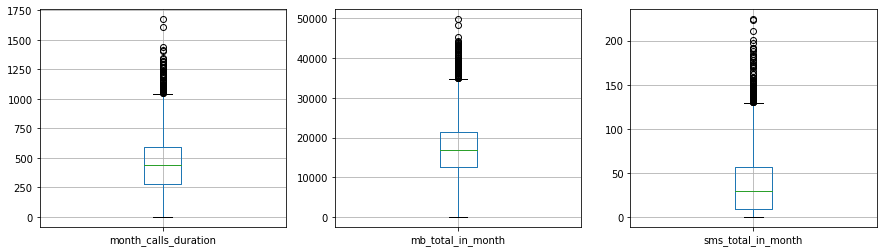

In [52]:
columns_list = ['month_calls_duration', 'mb_total_in_month', 'sms_total_in_month']
users_consumption[columns_list].plot(subplots=True, layout=(1, 3), 
                                    kind = 'box' 
                                   ,figsize=(15, 4)
                                   ,grid=True
                                      )

Рассчитаем границы для выбросов

In [53]:
for column in columns_list:
    print('------------------------\nДанные столбца {}\n------------------------'.format(column))
    q1=users_consumption[column].describe()[4]
    q3=users_consumption[column].describe()[6]
    iqr = q3 - q1
    top_edge = q3 + 1.5 * iqr
    print ('Верхняя граница {}'.format(top_edge))
    display(users_consumption[column].describe())

------------------------
Данные столбца month_calls_duration
------------------------
Верхняя граница 1049.5


count   3,214.00
mean      451.24
std       241.91
min         0.00
25%       282.00
50%       443.00
75%       589.00
max     1,673.00
Name: month_calls_duration, dtype: float64

------------------------
Данные столбца mb_total_in_month
------------------------
Верхняя граница 34823.72749999999


count    3,214.00
mean    17,207.61
std      7,570.96
min          0.00
25%     12,491.89
50%     16,943.18
75%     21,424.62
max     49,745.69
Name: mb_total_in_month, dtype: float64

------------------------
Данные столбца sms_total_in_month
------------------------
Верхняя граница 129.0


count   3,214.00
mean       38.28
std        36.15
min         0.00
25%         9.00
50%        30.00
75%        57.00
max       224.00
Name: sms_total_in_month, dtype: float64

Изучим данные по ключевым столбцам (звонки, трафик, сообщения) в преобразованной таблицы. Начнем с тарифа smart

In [54]:
users_consumption_summary_smart = pd.pivot_table(
    data=users_consumption.loc[users_consumption['tariff']=='smart'],
    index = 'month', values=columns_list , aggfunc=sum)
users_consumption_summary_smart

,mb_total_in_month,month_calls_duration,sms_total_in_month
month,,,
1,"289,466.40","6,931.00",620.00
2,"672,629.15","17,324.00","1,397.00"
3,"1,163,020.25","30,034.00","2,453.00"
4,"1,507,764.23","41,119.00","3,443.00"
5,"2,228,530.99","54,618.00","4,762.00"
6,"2,590,322.27","64,885.00","5,478.00"
7,"3,164,373.22","82,079.00","6,784.00"
8,"3,903,519.22","99,045.00","7,905.00"
9,"4,238,930.49","111,439.00","8,746.00"


Из таблицы видно, что с каждым месяцем потребление увеличивается.

In [55]:
 pd.pivot_table(data=users_consumption.loc[users_consumption['tariff']=='smart'],
    index = 'month', values='user_id' , aggfunc='count')

,user_id
month,
1,34
2,58
3,77
4,112
5,141
6,164
7,201
8,235
9,260


Это связанно с тем, что пользователей становится больше с каждым месяцем.

Теперь рассчитаем среднюю, дисперсию и стандартное отклонение, но уже без группировки по месяцам способом describe()

In [56]:
users_consumption_smart = users_consumption.loc[users_consumption['tariff']=='smart']
print('|Проверка с помощью .describe()|\n--------------------------------')
display(users_consumption_smart.describe().astype('int64'))

|Проверка с помощью .describe()|
--------------------------------


,user_id,month,month_calls_duration,calls_total_in_month,mb_total_in_month,sms_total_in_month,company_revenue
count,2229,2229,2229,2229,2229,2229,2229
mean,1246,8,417,58,16208,33,1289
std,146,2,190,25,5870,28,818
min,1001,1,0,0,0,0,550
25%,1121,6,282,40,12643,10,550
50%,1239,9,422,60,16506,28,1023
75%,1376,11,545,76,20042,51,1750
max,1499,12,1435,198,38552,143,6770


Средние значения для каждого месяца тарифа smart определены.

Расчитаем помесячное потребление минут/трафика/смс для ultra

In [57]:
users_consumption_summary_ultra = pd.pivot_table(
    data=users_consumption.loc[users_consumption['tariff']=='ultra'],
    index = 'month', values=columns_list , aggfunc=sum)
users_consumption_summary_ultra

,mb_total_in_month,month_calls_duration,sms_total_in_month
month,,,
1,"118,266.13","3,853.00",304.00
2,"282,622.50","7,131.00",527.00
3,"648,815.36","18,117.00","1,195.00"
4,"925,547.39","25,191.00","1,736.00"
5,"1,297,331.25","34,192.00","2,536.00"
6,"1,589,694.90","40,295.00","3,505.00"
7,"1,865,105.53","49,667.00","4,536.00"
8,"2,094,637.85","54,653.00","5,183.00"
9,"2,208,491.87","62,036.00","6,013.00"


In [58]:
users_consumption_ultra = users_consumption.loc[users_consumption['tariff']=='ultra']
users_consumption_ultra[columns_list].describe().astype('int64')

,month_calls_duration,mb_total_in_month,sms_total_in_month
count,985,985,985
mean,526,19468,49
std,317,10087,47
min,0,0,0
25%,284,11770,6
50%,518,19308,38
75%,752,26837,79
max,1673,49745,224


Посмотрим на различия тарифа смарт от ультра

In [59]:
for column in columns_list:
    mean_difference = round(users_consumption_smart[column].describe()[1] - users_consumption_ultra[column].describe()[1]
                            ,ndigits=1
                           )
    median_difference = round(users_consumption_smart[column].describe()[5] - users_consumption_ultra[column].describe()[5],
                             ndigits=1)
    print('Среднее значение {} тарифа smart отличается от  ultra на {}'.format(column, mean_difference))
    print('Медиана {} тарифа smart отличается от  ultra на {}\n____________________'.format(column, median_difference))

Среднее значение month_calls_duration тарифа smart отличается от  ultra на -108.7
Медиана month_calls_duration тарифа smart отличается от  ultra на -96.0
____________________
Среднее значение mb_total_in_month тарифа smart отличается от  ultra на -3260.4
Медиана mb_total_in_month тарифа smart отличается от  ultra на -2801.2
____________________
Среднее значение sms_total_in_month тарифа smart отличается от  ultra на -16.0
Медиана sms_total_in_month тарифа smart отличается от  ultra на -10.0
____________________


tariff
smart    351
ultra    149
Name: tariff, dtype: int64

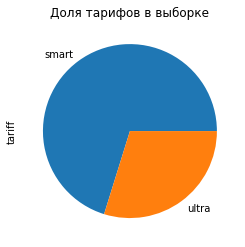

In [60]:
display(users.groupby('tariff')['tariff'].count())
users.groupby('tariff')['tariff'].count().plot(kind='pie',  title='Доля тарифов в выборке')
plt.show()

Пользователи тарифа ultra говорят в среднем на час дольше чем пользователя тарифа smart. Так же им, как правило, требуется больше интренет-трафика.

Общее потребление пользователей тарифа smart по всем статьям выше тарифа ultra. Как минимум потому, что таких пользователей у нас больше. Интересно будет узнать как обстоит ситуация с выручкой от этих тарифов.

Но прежде чем приступить к проверке гипотиз, посмотрим на распределение этих тарифов. Построим гистограммы плотности для каждого интересующего значения по каждому из тарифов.

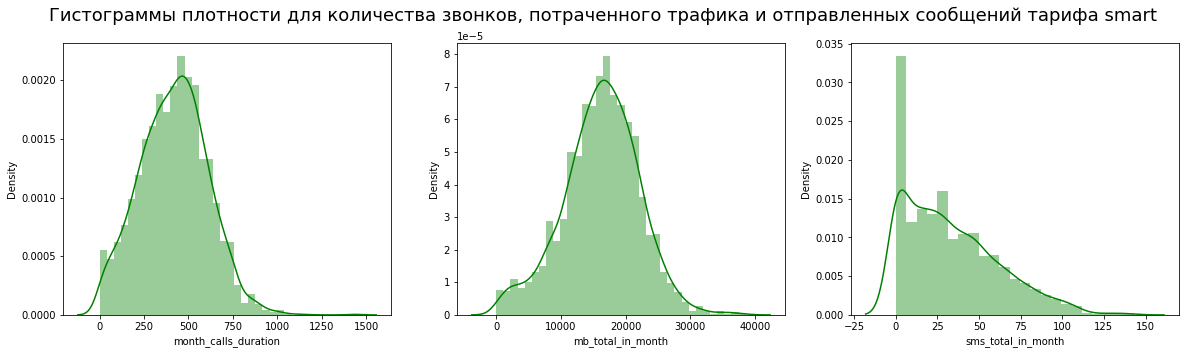

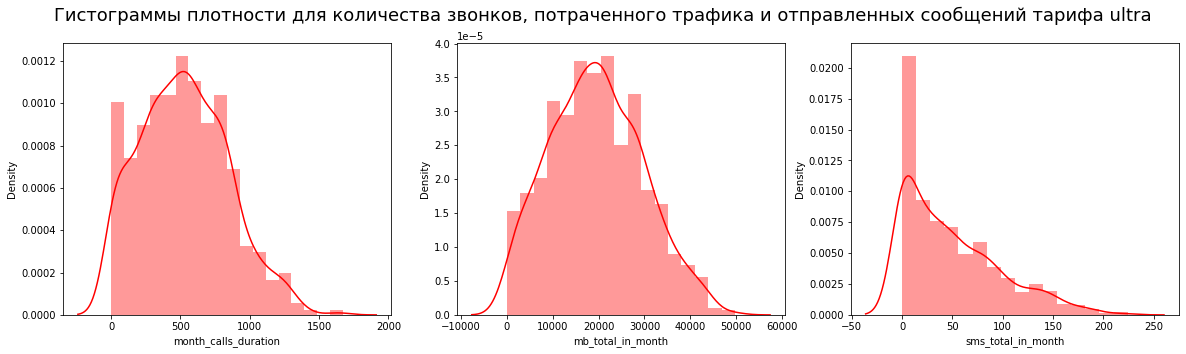

In [61]:
fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для количества звонков, потраченного трафика и отправленных сообщений тарифа smart',fontsize=18)
for i, column in enumerate(columns_list):
    sns.distplot(users_consumption_smart[column], ax=axs[i], color='green')
    
plt.show()

fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для количества звонков, потраченного трафика и отправленных сообщений тарифа ultra',fontsize=18)
for i, column in enumerate(columns_list):
    sns.distplot(users_consumption_ultra[column], ax=axs[i], color='red')

**Вывод**

Распределения обоих тарифов имеют схожие формы. Клиенты ведут себя примерно одинаково. Для звонков и трафика график почти симметричный, немного скошен влево. Сообщения же ассиметричны ввиду того, что мало кто использует сообщения. Так как тариф ультра включает в себя больше минут/мб/сообщений видим, что их потребление в тарифе ультра больше, чем у смарт

## Шаг 4. Проверка гипотезы

Приступим к проверке гипотиз и решим, какой же тариф лучше.

Первая - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» различается

Будем проверять две генеральные совокупности на равенство их средних (st.ttest_ind). Считаем, что первая ген совокупность это клиенты тарифа smart, вторая ultra. У нас больше 30 наблюдений в каждой выборке, соответственно можем применить t-критерий. Приступим к формулированию гипотиз исходя из поставленной задачи, держим в голове, что нулевая гипотеза всегда формируется со знаком равенства.

Гипотизы для стат анализа:

Н0 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» одинаковая

H1 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» отличается

Уровень значимости зададим равным 5%

Прежде чем приступить, сравним дисперсии выборок (чтобы корректно выбрать значени аргумента equal_var метода st.ttest_ind.

In [ ]:
ultra = users_consumption_clean.query("tariff == 'ultra'")
smart = users_consumption_clean.query("tariff == 'smart'")

In [ ]:
print('Дисперсия выручки тарифа smart - {}'.format(int(smart['company_revenue'].describe()[2])**2))
print()
print('Дисперсия выручки тарифа ultra - {}'.format(int(ultra['company_revenue'].describe()[2])**2))

Видим значительное отличие, в процессе проведения t-теста в методе пропишем equal_var=False.

Подготовка закончена, приступим к проверке первой гипотезы.

In [ ]:
result = st.ttest_ind(smart['company_revenue'], ultra['company_revenue'], equal_var=False)
print('p-значение:', round(result.pvalue,ndigits=5))

p-уровень значимости получился очень очень маленьким, что свидетельствует о ничтожно малом шансе жизнеспособности нашей нулевой гипотезы при условии, что H0 верна. Тоже самое справедливо, задай мы уровень значимости 1%

Таким образом, Н0 отвергается, средняя выручка компании от тарифов Смарт и Ультра отличается.

In [ ]:
print('Средняя вырочка компании от тарифа smart - {} руб'.format(round(smart['company_revenue'].describe()[1],ndigits=1)))
print('Вырочка компании от тарифа smart - {} руб'.format(smart['company_revenue'].sum()))
print()
print('Средняя вырочка компании от тарифа ultra - {} руб'.format(round(ultra['company_revenue'].describe()[1],ndigits=1)))
print('Вырочка компании от тарифа ultra - {} руб'.format(ultra['company_revenue'].sum()))

Средняя выручка компании от одного пользователя тарифа ultra больше, чем от smart. Кроме того, можно сделать вывод, что пользователи тариф ultra, в отличии от smart, укладываются в рамки своего тарифного плана и редко доплачивают за доп минуты/трафик/сообщения. Так как средняя выручка компании примерно равна стоимости пакета.

Суммарные же показатели указывают на то, что в нашей выборке больше клиентов с тарифом smart, тем не менее, около 35% процентов всей выручки составляет выручка от тарифа ultra.


Приступим к проверке второй гипотезы - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Тест проведем по аналогии с предыдущим, пользователи из Москвы одна ген совокупность, остальные - другая. Для этого наложим фильтры на таблицу users_consumption_clean, проверим равенство дисперсий и проверим гипотезу.

Гипотизы для стат анализа:

Н0 - средняя выручка компании в Москве равна выручке из других регионов

H1 - средняя выручка компании в Москвы НЕ равна выручке из других регионов

Уровень значимости установим на уровне 5%

In [ ]:
mosсow_revenue = users_consumption_clean.loc[users_consumption_clean['city']== 'Москва','company_revenue'] 
mosсow_revenue.sample(3)

In [ ]:
regions_revenue = users_consumption_clean.loc[users_consumption_clean['city'] != 'Москва','company_revenue'] 
regions_revenue.sample(3)

In [ ]:
print('Дисперсия выручки в Москве - {}'.format(int(mosсow_revenue.describe()[2])**2))
print()
print('Дисперсия выручки в регионах - {}'.format(int(regions_revenue.describe()[2])**2))

Получается не очевидно, проверим при помощи теста Левена, зададим уровень значимости 5%

In [ ]:
stat, p = st.levene(mosсow_revenue, regions_revenue)
print(p)

p-значение теста Левена оказалось меньше 5%, значит отвергаем нулевую гипотезу о равенстве дисперсий наших выборок, устанавливаем equal_var=False

In [ ]:
result = st.ttest_ind(mosсow_revenue, regions_revenue, equal_var=False)
print('p-значение:', round(result.pvalue,ndigits=5))

p-уровень значимости получился равен 42%, что не позволяет нам отвергнуть нулевую гипотизу.

Следовательно, выручка компании в Москве не отличается от выручки в регионах.

**Вывод**

При помощи t-теста (так как выборки содержат > 30 наблюдений) для выборок из двух разных генеральных совокупностей было проверено две гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» 
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов 

Первая гипотеза подтвердилась, средняя выручка отличается, так же увидели, что средняя выручка тарифа ultra - больше. В тоже время, пользователи тарифа smart, как правило, докупают минуты/трафик/сообщения.

Вторая гипотеза не подтвердилась, нет разницы в выручке между Москвой и регионами

## Общий вывод

В ходе анализа было изучено два тарифа телеком компании - smart & ultra. А именно:

Качество данных оказалось на достаточно высоком уровне, большой предобработки не потребовалось.

Была подготовлена таблица с общим потреблением минут/трафика/сообщений для каждого пользователя в месяц, а так же рассчитана прибыль компании для каждого месяца.

Из последующего анализа исключили месяца, в которых пользователи израсходовали слишком много минут/трафика/сообщений

Распределение потребления минут и трафика нормальное, в то время как у сообщений сильно скошено вправо. Что указывает на не популярность СМС. Так же в процессе анализа выяснили, что в выборке больше клиентов с тарифом smart, что значительно сказывается на разнице потраченных минут/трафика/сообщений м/у тарифами.

Перспективный тариф: С большой долей вероятность было установлено, что средняя выручка у разных тарифов не равна, и средняя выручка от клиента тарифа ultra оказалась выше, чем у тарифа smart.